# Análisis de datos

Aquí hemos analizado y transformado los datos para que sean tratables por los diiferentes enfoques de Redes:

* No he usado técnicas de reducción de dimensionalidad (com o PCA) ya que tenemos muy pocas vairables.
* He aplicado one-shot para todas las variables que he considerado categóricas, no me han hecho falta embeddings.

In [1]:
import pandas as pd
import os
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
import math

# Variables globales

In [2]:
RUTA_DATOS = r"C:\Users\jaume\Documents\Proyecto\datos"
FIC_ENTRADA="02_datos_limpios_sin_parada.pkl"
FIC_SALIDA='data_and_scaler.joblib'

# Carga de datos y eliminación de columnas no usables

Ya que no vamos a usar para el proyecto los datos atmosféricos, los quitamos.

Por otro lado, las columnas de "x_base" y "Delta_E" tampoco tienen sentido en este momento.

In [3]:
os.chdir(RUTA_DATOS)

# Cargar el objeto desde el fichero
with open(FIC_ENTRADA, 'rb') as f:
    df_prep = pickle.load(f)

df_prep.columns

Index(['tmin', 'tmed', 'tmax', 'horatmin', 'horatmax', 'hrMin', 'hrMedia',
       'hrMax', 'horaHrMin', 'horaHrMax', 'estado', 'velocidad', 'L', 'L_base',
       'A', 'A_base', 'B', 'B_base', 'Delta_E', 'patron_id', 'hour_sin',
       'hour_cos', 'duracion_parada_anterior', 'tiempo_en_estado', 'seq_time'],
      dtype='object')

In [4]:
columnas_ambiente_a_quitar = ['tmin', 'tmed', 'tmax', 'horatmin', 'horatmax', 'hrMin', 'hrMedia',
                             'hrMax', 'horaHrMin', 'horaHrMax']
df_prep.drop(columnas_ambiente_a_quitar, axis=1, inplace=True)

columnas_color_a_quitar = [ 'L_base', 'A_base', 'B_base', 'Delta_E' ]
df_prep.drop(columnas_color_a_quitar, axis=1, inplace=True)

# Cambio de índice

Aunque no es estrictamente necesario voy a cambiar el índice para que sea seq_time ya que las horas ya no vienen correlativas y también porque nos ahorrará cómputo al ser mas sencillo indexar por un *number* que por un *datetime*.

In [5]:
df_prep.set_index('seq_time', inplace=True)

# Análisis de tipos de datos

La mayoría de las variables son numéricas excepto `estado` aunque, `patron_id` es númerica la trataré como una variable categórica pues me indica el patrón por tanto la pasaré a *object*.

In [6]:
# Mostrar las primeras filas del DataFrame
print(df_prep.dtypes)

# Convierto el patron_id a "object"
df_prep["patron_id"] = df_prep["patron_id"].astype("object")
print(df_prep.dtypes)

# Pongo las variables numéricas y las categóricas en sus respectivas variables
categorical_cols = df_prep.select_dtypes(include=['object', 'category']).columns
numerical_cols = df_prep.select_dtypes(include=['number']).columns

estado                       object
velocidad                   float64
L                           float64
A                           float64
B                           float64
patron_id                     int64
hour_sin                    float64
hour_cos                    float64
duracion_parada_anterior    float64
tiempo_en_estado              int64
dtype: object
estado                       object
velocidad                   float64
L                           float64
A                           float64
B                           float64
patron_id                    object
hour_sin                    float64
hour_cos                    float64
duracion_parada_anterior    float64
tiempo_en_estado              int64
dtype: object


# Análisis de nulos

Dado que he quitado los nulos en los datos metereológicos en el momento de incorporarlos (imputamos los valores que eran nulos) y dado que el resto de datos son sintéticos no habría que encontrar ningún dato nulo.

De todas maneras mejor mirarlo ya que en el caso de que los datos fueran reales debería de hacerlo sí o sí.

In [7]:
# Verificar valores nulos
print(df_prep.isnull().sum())


estado                      0
velocidad                   0
L                           0
A                           0
B                           0
patron_id                   0
hour_sin                    0
hour_cos                    0
duracion_parada_anterior    0
tiempo_en_estado            0
dtype: int64


# Análisis y visualizacion de variables

A partir del resumen estadístico se pueden hacer varias observaciones:

1. Escalas muy diferentes:
    - Variables como velocidad, L, A, B y tiempo_en_estado tienen medias, desviaciones estándar y rangos muy distintos. Por ejemplo, “velocidad” varía entre 10 y 510, mientras que “L” va aproximadamente de 47 a 153.
    - A y B tienen rangos amplios (aproximadamente de –92 a 107 y de –91 a 99 respectivamente) y distribuciones que no están centradas en 0.
    - Aquí usaré **StandarScaler()** 

2. Variables que ya están en un rango “normalizado”:
    - Las variables hour_sin y hour_cos están en el rango [–1, 1] (ya que provienen de la función seno y coseno), por lo que no requieren normalización adicional.

3. Variables especiales:
    - duracion_parada_anterior:
        - Tiene muchos valores en 0 (mediana 0, y los percentiles 25 y 50 son 0) pero presenta algunos valores atípicos (valor máximo 60.48). Esto sugiere una distribución muy sesgada, por lo que podría beneficiarse de una normalización robusta (por ejemplo, mediante RobustScaler), ya que este método reduce el efecto de los outliers.
        - Como creo que esta variable puede ayudar al modelo a converger mejor, no la eliminaré.
        - En un inicio lo escalé usando *StandarScaler()* pero las predicciones mejoraron cuando usé **RobustScaler()**.
  
4. Variables categóricas:
    - patron_id:
        - Aunque parecen valores numéricos (con valores entre 0 y 100 aprox.), para mí son variables categóricas que identifican patrones de impresión.
        - Cómo no son muchas variables usaré **codificación one-hot** en vez de embeddings. Si fueran más de mil tal vez me plantearía el uso de embeddings.
    - estado:
        - Una vez eliminado el estado *parada* solo quedan 3.
        - Aquí claramente usaré **codificación one-hot**.

**Relevancia para redes LSTM y Transformers:**

    - Las redes neuronales recurrentes (LSTM) y las arquitecturas transformer son muy sensibles a la escala de las entradas.
    - Normalizar (o estandarizar) las variables que tienen rangos muy diferentes ayuda a que el entrenamiento sea más estable y a que la convergencia se logre más rápidamente.
    - En general, se suele usar la normalización Z-score (StandardScaler) para centrar las variables en 0 con una desviación estándar de 1.
    - Para variables con outliers marcados (como duracion_parada_anterior), RobustScaler es recomendable ya que utiliza la mediana y el rango intercuartílico, minimizando el efecto de los valores extremos.

In [8]:
# Cantidad de datos
print(f"Total de mediciones (número de filas): {len(df_prep)}")

# Resumen estadístico de las columnas numéricas
print("\nVariables numéricas\n===================")
print(df_prep.describe())

# Resumen de las columna categóricas
print("\nVariables categóricas\n=====================")
print(f"Número de 'patron_id' diferentes: {df_prep['patron_id'].nunique()}")
print(f"Número de 'estado' diferentes: {df_prep['estado'].nunique()}")


Total de mediciones (número de filas): 270958

Variables numéricas
           velocidad              L              A              B  \
count  270958.000000  270958.000000  270958.000000  270958.000000   
mean      375.866020      74.953009     -11.409485       2.104687   
std        87.547455      13.151025      49.600622      51.386035   
min        10.000000      46.607209    -101.077586     -97.290139   
25%       317.587281      64.262852     -52.407206     -53.845030   
50%       335.816169      74.731583     -18.928440      18.765805   
75%       493.554130      83.051583      25.838026      42.135196   
max       510.000000     128.971583      95.333651      93.834430   

           hour_sin      hour_cos  duracion_parada_anterior  tiempo_en_estado  
count  2.709580e+05  2.709580e+05             270958.000000     270958.000000  
mean   3.094356e-18 -9.381528e-03                  0.027019        533.266458  
std    7.104172e-01  7.037209e-01                  1.075154        495.

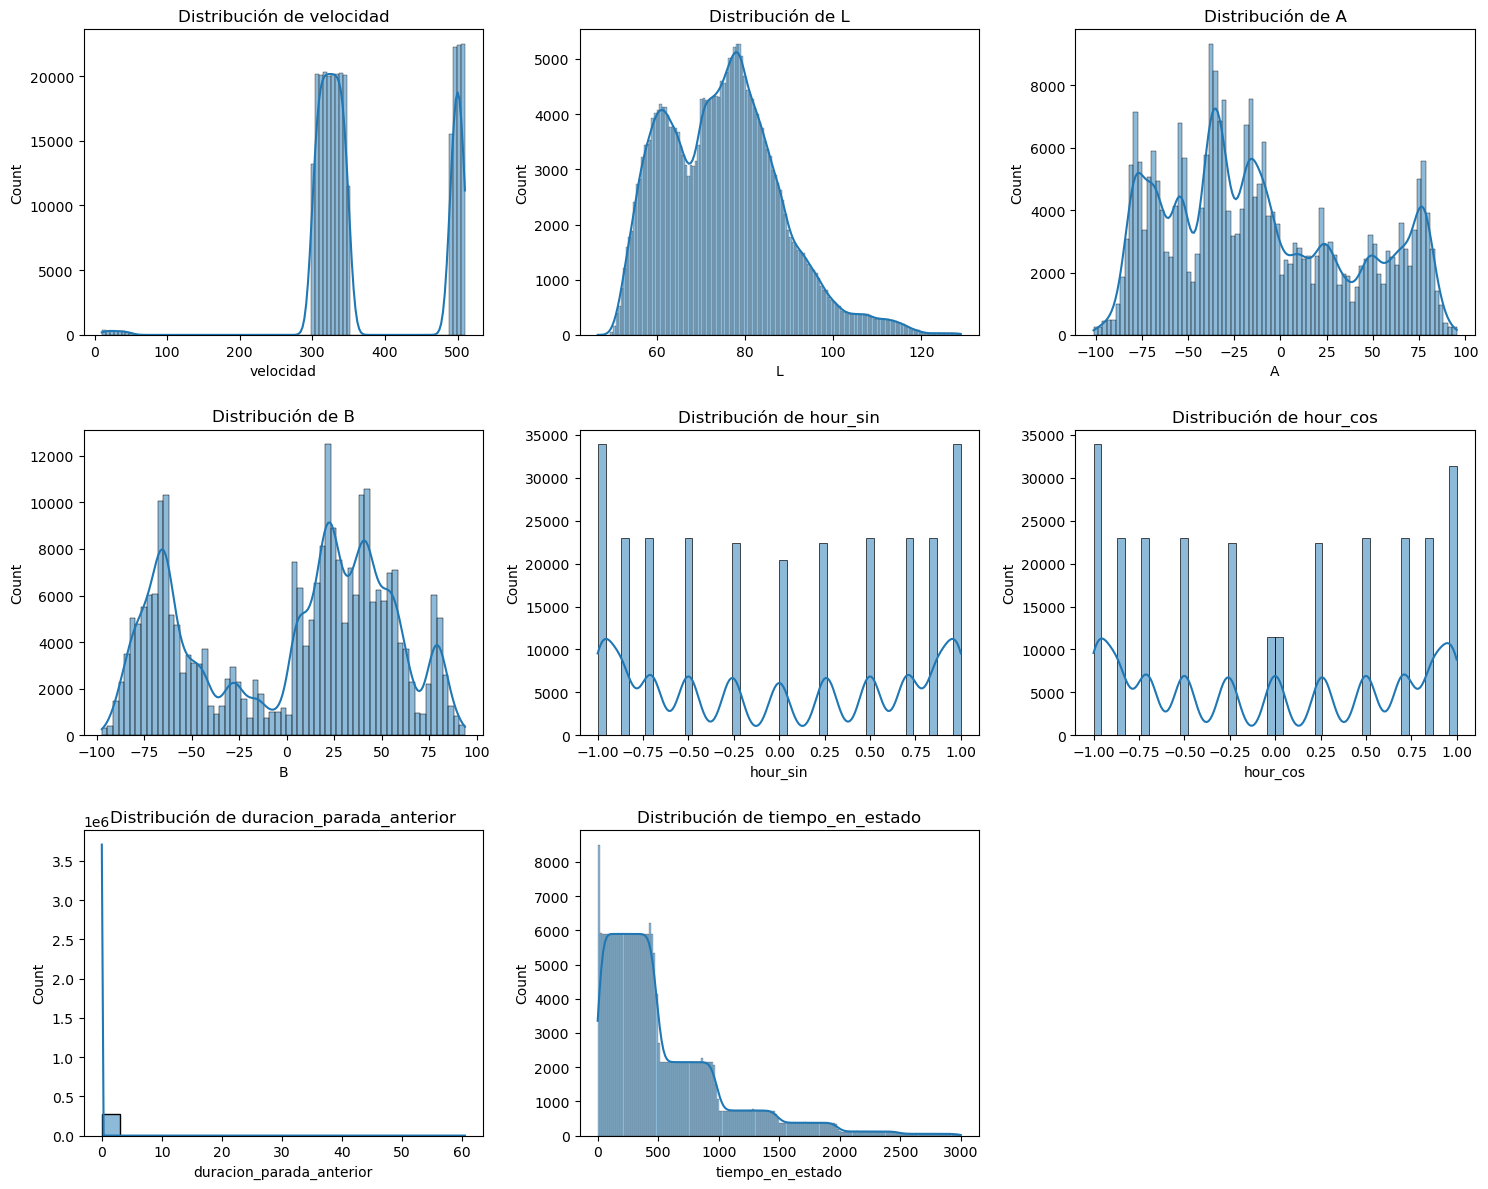

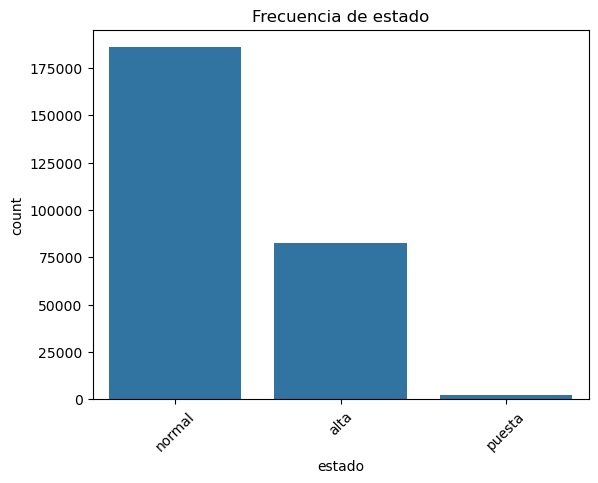

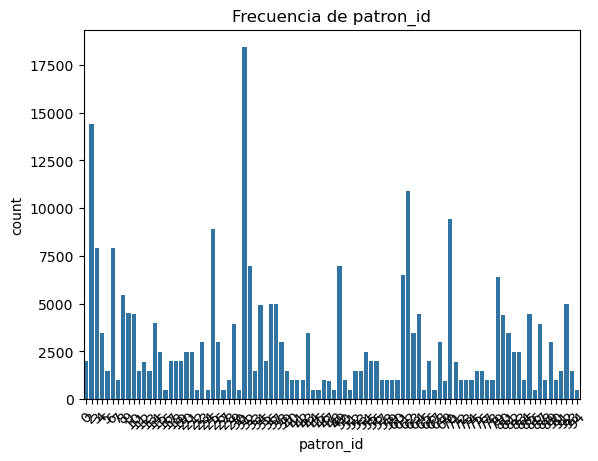

In [9]:
# ------------------------------
# Visualización para columnas numéricas
# ------------------------------
n_num = len(numerical_cols)
n_cols = 3
n_rows = math.ceil(n_num / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
# En caso de tener solo una fila, axs es un array 1D; lo aplanamos para un manejo uniforme:
axs = axs.flatten() if n_num > 1 else [axs]

for i, col in enumerate(numerical_cols):
    sns.histplot(df_prep[col], kde=True, ax=axs[i])
    axs[i].set_title(f"Distribución de {col}")

# Eliminar los ejes vacíos si los hubiera
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# ------------------------------
# Visualización para columnas categóricas
# ------------------------------
for col in categorical_cols:
    sns.countplot(x=col, data=df_prep)
    plt.title(f"Frecuencia de {col}")
    plt.xticks(rotation=45)
    plt.show()

# Transformación de datos

Solo quiero hacer notar aquí no hará falta tratar de disminuir la dimensionalidad (con análisis PCA por ejemplo) ya que el número de variables no son muchas.

## Transformaciones *StandarScaler()* y *RobustScaler()*

**Datos a estandarizar o escalar usando *StandarScaler()***

* **velocidad (float64)**: Como vemos en las gráficas, los datos aquí son multimodales, es decir, tienen diferentes picos, lo que es evidente ya que nos referimos a 3 tipos diferentes de velocidad (puesta, normal, alta). Por tanto, creo que estandarizar es lo mejor en este caso.
* **L,A,B (float64)**: Variables objetivo. Podría dejarlas como están pero en la práctica me ha dado peores convergencias así que, les aplicaré una estadarización.
* **tiempo_en_estado (int64)** Usaré la estadarización usando *RobustScaler()* pero antes le aplicaré el logaritmo pues parece que de esta manera puede parecerse más a una distribución normal.

**Robust Scaler**

* **duracion_parada_anterior (float64)**: Usaré la estadarización usando *RobustScaler()* pero antes le aplicaré el logaritmo pues de esta manera los valores quedan acotados en un rango no tan amplio.

Para todas estas guardaré la estandarización para luego poder regresarlos a la escala real con **inverse_transform**.

           velocidad              L              A              B  \
count  270958.000000  270958.000000  270958.000000  270958.000000   
mean      375.866020      74.953009     -11.409485       2.104687   
std        87.547455      13.151025      49.600622      51.386035   
min        10.000000      46.607209    -101.077586     -97.290139   
25%       317.587281      64.262852     -52.407206     -53.845030   
50%       335.816169      74.731583     -18.928440      18.765805   
75%       493.554130      83.051583      25.838026      42.135196   
max       510.000000     128.971583      95.333651      93.834430   

           hour_sin      hour_cos  duracion_parada_anterior  tiempo_en_estado  \
count  2.709580e+05  2.709580e+05             270958.000000     270958.000000   
mean   3.094356e-18 -9.381528e-03                  0.027019        533.266458   
std    7.104172e-01  7.037209e-01                  1.075154        495.371811   
min   -1.000000e+00 -1.000000e+00                  0.0

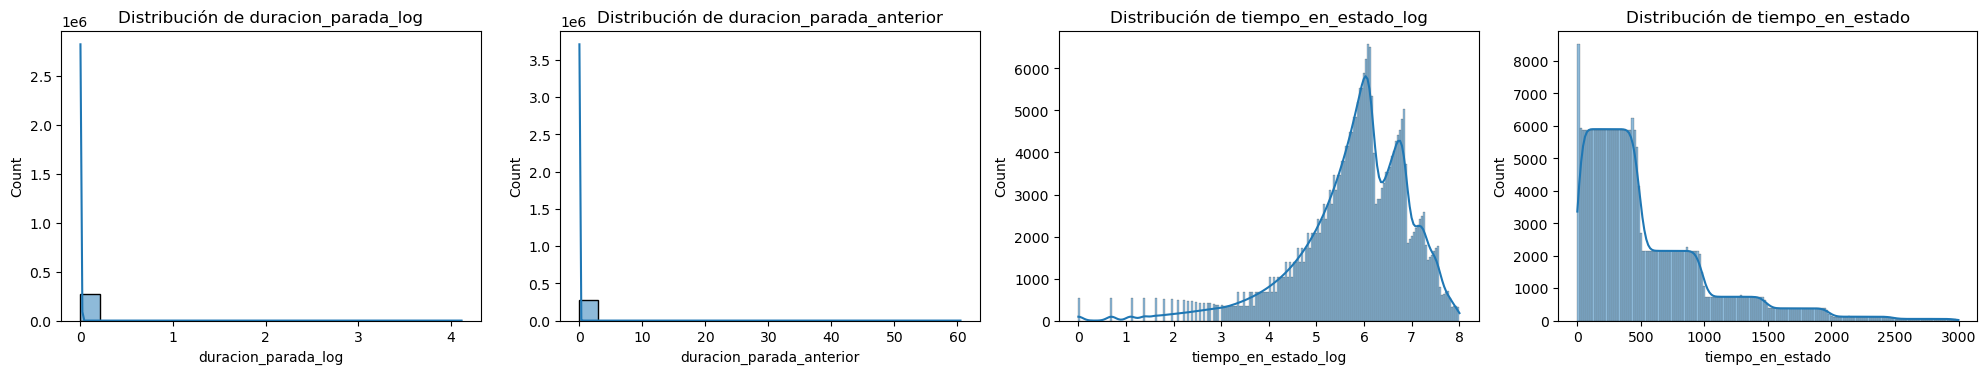

In [10]:
# Usaremos log1p para evitar log(0) ya que log1p hace log(n+1)
df_prep['duracion_parada_log'] = np.log1p(df_prep['duracion_parada_anterior'])
df_prep['tiempo_en_estado_log'] = np.log1p(df_prep['tiempo_en_estado'])

# Resumen estadístico de las columnas numéricas
print(df_prep.describe())

columnas_vis=['duracion_parada_log', 'duracion_parada_anterior', 'tiempo_en_estado_log', 'tiempo_en_estado']

n_num = len(columnas_vis)
n_cols = 4
n_rows = math.ceil(n_num / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
# En caso de tener solo una fila, axs es un array 1D; lo aplanamos para un manejo uniforme:
axs = axs.flatten() if n_num > 1 else [axs]

for i, col in enumerate(columnas_vis):
    sns.histplot(df_prep[col], kde=True, ax=axs[i])
    axs[i].set_title(f"Distribución de {col}")

# Eliminar los ejes vacíos si los hubiera
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [11]:
quitar=['duracion_parada_anterior', 'tiempo_en_estado']
df_prep.drop(quitar, axis=1, inplace=True)
df_prep.describe()

,velocidad,L,A,B,hour_sin,hour_cos,duracion_parada_log,tiempo_en_estado_log
count,270958.000000,270958.000000,270958.000000,270958.000000,2.709580e+05,2.709580e+05,270958.000000,270958.000000
mean,375.866020,74.953009,-11.409485,2.104687,3.094356e-18,-9.381528e-03,0.002550,5.778409
std,87.547455,13.151025,49.600622,51.386035,7.104172e-01,7.037209e-01,0.096320,1.197334
min,10.000000,46.607209,-101.077586,-97.290139,-1.000000e+00,-1.000000e+00,0.000000,0.000000
25%,317.587281,64.262852,-52.407206,-53.845030,-7.071068e-01,-7.071068e-01,0.000000,5.247024
50%,335.816169,74.731583,-18.928440,18.765805,1.224647e-16,-1.836970e-16,0.000000,5.953243
75%,493.554130,83.051583,25.838026,42.135196,7.071068e-01,7.071068e-01,0.000000,6.612041
max,510.000000,128.971583,95.333651,93.834430,1.000000e+00,1.000000e+00,4.118712,8.006368


In [12]:
var_standar_scaler = [ 'L','A','B','tiempo_en_estado_log','velocidad' ]
df_std = df_prep[var_standar_scaler].copy()  # shape (N, 6)

#### Estandarización (escalado)
scaler = StandardScaler()
scaler.fit(df_std)
df_scaled = scaler.transform(df_std)

# Añado las columnas escaladas al dataframe principal
df_prep['L_scaled'] = df_scaled[:,0]
df_prep['A_scaled'] = df_scaled[:,1]
df_prep['B_scaled'] = df_scaled[:,2]
df_prep['tiempo_en_estado_scaled'] = df_scaled[:,3]
df_prep['velocidad_scaled'] = df_scaled[:,4]

# Escalar 'duracion_parada_log' con RobustScaler para mayor robustez frente a outliers
scaler_robust = RobustScaler()
df_prep[['duracion_parada_robust_scaled']] = scaler_robust.fit_transform(df_prep[['duracion_parada_log']])

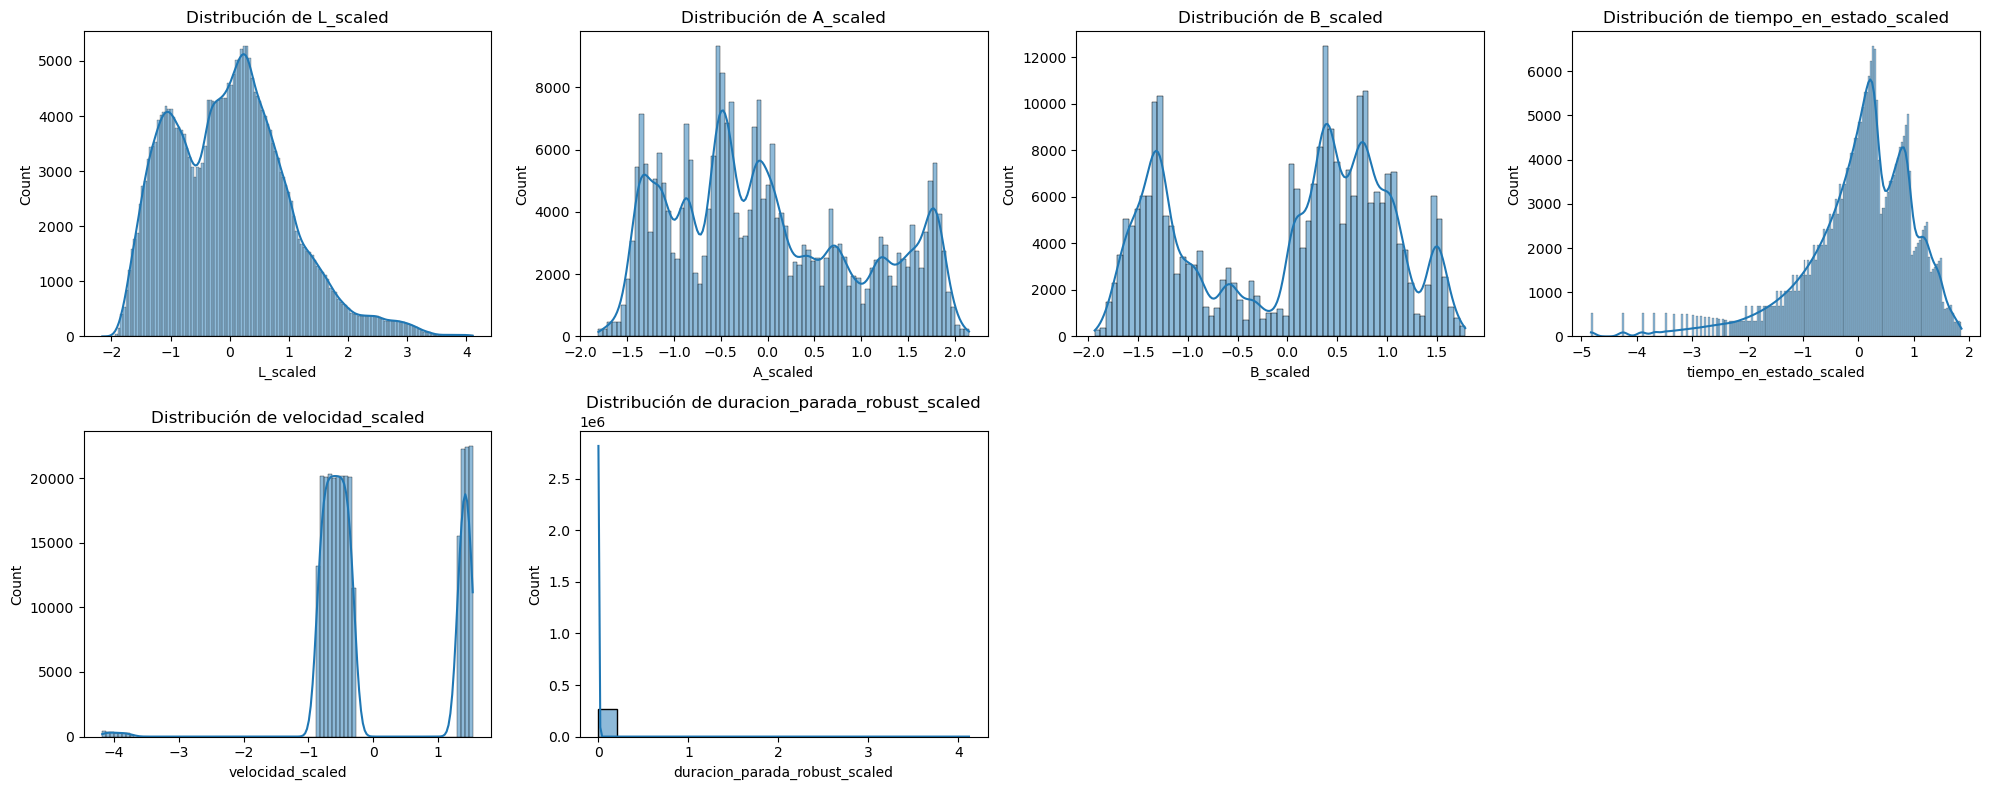

In [13]:
columnas_escaladas=['L_scaled', 'A_scaled', 'B_scaled', 'tiempo_en_estado_scaled', 'velocidad_scaled',
                    'duracion_parada_robust_scaled']
df_final = df_prep[columnas_escaladas].copy()

n_num = len(columnas_escaladas)
n_cols = 4
n_rows = math.ceil(n_num / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
# En caso de tener solo una fila, axs es un array 1D; lo aplanamos para un manejo uniforme:
axs = axs.flatten() if n_num > 1 else [axs]

for i, col in enumerate(columnas_escaladas):
    sns.histplot(df_final[col], kde=True, ax=axs[i])
    axs[i].set_title(f"Distribución de {col}")

# Eliminar los ejes vacíos si los hubiera
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [14]:
df_final.describe()

,L_scaled,A_scaled,B_scaled,tiempo_en_estado_scaled,velocidad_scaled,duracion_parada_robust_scaled
count,2.709580e+05,2.709580e+05,2.709580e+05,2.709580e+05,2.709580e+05,270958.000000
mean,-5.453933e-16,-7.510368e-17,-1.374104e-17,3.704835e-16,7.685540e-16,0.002550
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.096320
min,-2.155410e+00,-1.807805e+00,-1.934281e+00,-4.826073e+00,-4.179067e+00,0.000000
25%,-8.128778e-01,-8.265581e-01,-1.088814e+00,-4.438074e-01,-6.656829e-01,0.000000
50%,-1.683719e-02,-1.515902e-01,3.242349e-01,1.460204e-01,-4.574653e-01,0.000000
75%,6.158143e-01,7.509499e-01,7.790168e-01,6.962421e-01,1.344280e+00,0.000000
max,4.107564e+00,2.152056e+00,1.785114e+00,1.860771e+00,1.532132e+00,4.118712


## Transformaciones variables categóricas con one-hot

No quitaremos una columna (como pasaría normalmente en las regresiones) para evitar la colinealidad debido a que los transformers y los RNN no tienen problemas de colinealidad y pueden beneficiarse de más información.

* **patron_id (int64)**: Las posibilidades que veo aquí es la de usar embeddings o bien one-hot enconding. Como no preveemos miles de patrones, hacer one-hot no será un gran problema en un inicio.
* **estado (object)**: Lo mismo que en caso anterior, en este son 3 estados ya que el estado parada ya ha sido eliminado previamente.


In [15]:
df_final['patron_id'] = df_prep['patron_id']
df_final['estado'] = df_prep['estado']

#### One-hot
# Aseguramos que sean tipo 'object'
df_final['patron_id'] = df_final['patron_id'].astype('object')
df_final['estado'] = df_final['estado'].astype('object')

# Generamos las columnas dummy
df_final = pd.get_dummies(df_final, columns=['patron_id'], prefix='patron')
df_final = pd.get_dummies(df_final, columns=['estado'], prefix='estado')

In [16]:
df_final.columns

Index(['L_scaled', 'A_scaled', 'B_scaled', 'tiempo_en_estado_scaled',
       'velocidad_scaled', 'duracion_parada_robust_scaled', 'patron_0',
       'patron_2', 'patron_3', 'patron_4',
       ...
       'patron_88', 'patron_89', 'patron_90', 'patron_91', 'patron_92',
       'patron_93', 'patron_94', 'estado_alta', 'estado_normal',
       'estado_puesta'],
      dtype='object', length=103)

## Matriz de correlación


Aunque para los modelos transformers y modelos RNN no es necesario analizar mucho las correlaciones puesto que:

* Capacidad de aprendizaje: Los modelos LSTM y Transformers son capaces de capturar relaciones complejas, incluso cuando algunas variables están altamente correlacionadas.
* Redundancia: Variables muy correlacionadas pueden aportar información redundante. Esto puede aumentar la complejidad del modelo sin mejorar significativamente el desempeño.

De todas maneras como vemos a continuación, no hay grandes correlaciones.

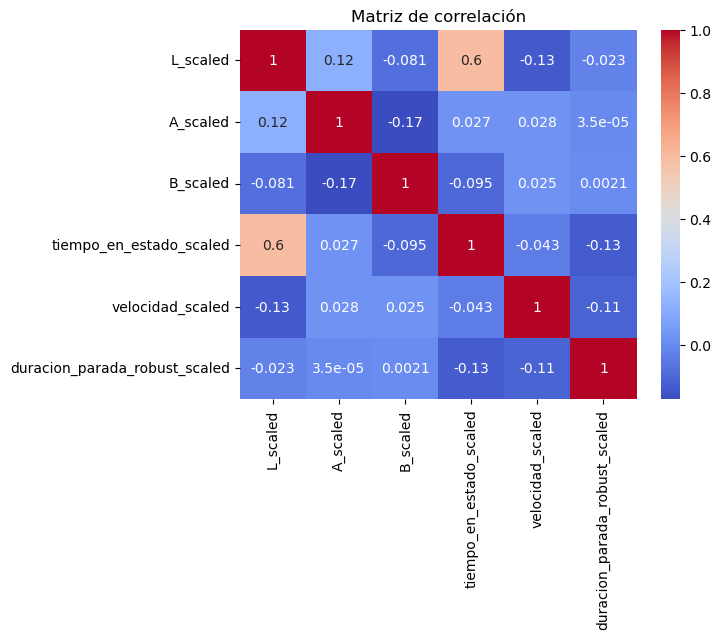

In [17]:
# Identificar columnas categóricas y numéricas
categorical_cols = df_final.select_dtypes(include=['object', 'category']).columns
numerical_cols = df_final.select_dtypes(include=['number']).columns

# Correlación entre variables numéricas
corr_matrix = df_final[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

# Cambio de tipos de columnas

Tengo muchas columnas que son de tipo booleanas, estas las transformaré en "int8"

In [18]:
bool_cols = [c for c in df_final.columns if df_final[c].dtype == 'bool']
for c in bool_cols:
    df_final[c] = df_final[c].astype('int8')
#df_utiles.dtypes

# Guardar datos y escalados

En este punto ya tenemos todos los datos adaptados para poder trabajarlos. Antes de proceder a manipularlos, lo que voy a hacer es guardarlos en un *pickle* tanto los datos como el escalado usado para luego poder invertir el escalado.

In [19]:
# Guardar en un archivo
with open(FIC_SALIDA, 'wb') as file:
    joblib.dump({'dataframe': df_final, 'scaler': scaler}, file)


##### Para luego recuperarlo:
# Cargar desde el archivo
#with open('data_and_scaler.pkl', 'rb') as file:
#    saved_objects = pickle.load(file)

# Recuperar DataFrame y scaler
#df = saved_objects['dataframe']
#scaler = saved_objects['scaler']

# Usar el scaler para inverse_transform
#scaled_values = scaler.inverse_transform(df[['L_scaled', 'A_scaled', 'B_scaled']])
#print(scaled_values)
